In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

## Explorar Datos

In [2]:
path='../data/full_devices.csv'
df = pd.read_csv(path, encoding='Latin-1')
df.head(2)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0


In [3]:

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['device', 'date']).reset_index(drop=True)
print(f'Shape: {df.shape}')
print(f'Periodo: {df["date"].min()} a {df["date"].max()}')
print(f'Devices únicos: {df["device"].nunique()}')
print(f'Columnas: {list(df.columns)}')
df.head()

Shape: (124494, 12)
Periodo: 2015-01-01 00:00:00 a 2015-11-02 00:00:00
Devices únicos: 1169
Columnas: ['date', 'device', 'failure', 'attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-02,S1F01085,0,1650864,56,0,52,6,407438,0,0,7
2,2015-01-03,S1F01085,0,124017368,56,0,52,6,407438,0,0,7
3,2015-01-04,S1F01085,0,128073224,56,0,52,6,407439,0,0,7
4,2015-01-05,S1F01085,0,97393448,56,0,52,6,408114,0,0,7


In [4]:
# positivo no tener datos nullos 
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        124494 non-null  datetime64[ns]
 1   device      124494 non-null  object        
 2   failure     124494 non-null  int64         
 3   attribute1  124494 non-null  int64         
 4   attribute2  124494 non-null  int64         
 5   attribute3  124494 non-null  int64         
 6   attribute4  124494 non-null  int64         
 7   attribute5  124494 non-null  int64         
 8   attribute6  124494 non-null  int64         
 9   attribute7  124494 non-null  int64         
 10  attribute8  124494 non-null  int64         
 11  attribute9  124494 non-null  int64         
dtypes: datetime64[ns](1), int64(10), object(1)
memory usage: 11.4+ MB


In [5]:
desc = df.describe()
df_comparacion = desc.loc[['50%', 'mean']]
df_comparacion.loc['diferencia'] = df_comparacion.loc['mean'] - df_comparacion.loc['50%']
df_comparacion.loc['unique'] = df.select_dtypes(exclude=['object']).nunique()
df_comparacion.round(1).T

,50%,mean,diferencia,unique
date,2015-03-27 00:00:00,2015-04-16 05:20:49.737336832,20 days 05:20:49.737336832,304
failure,0.0,0.0,0.0,2.0
attribute1,122797388.0,122388103.2,-409284.8,123877.0
attribute2,0.0,159.5,159.5,558.0
attribute3,0.0,9.9,9.9,47.0
attribute4,0.0,1.7,1.7,115.0
attribute5,10.0,14.2,4.2,60.0
attribute6,249799.5,260172.7,10373.2,44838.0
attribute7,0.0,0.3,0.3,28.0
attribute8,0.0,0.3,0.3,28.0


<Axes: >

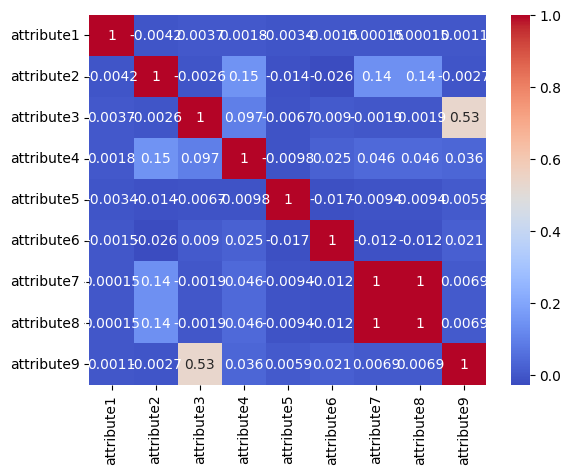

In [6]:
attributes = [col for col in df.columns if col.startswith('attribute')]
sns.heatmap(df[attributes].corr(), annot=True, cmap='coolwarm')

In [7]:
df[['attribute7','attribute8']].sort_values(by='attribute7',
    ascending=False).apply(lambda x: x['attribute8']-x['attribute7'],axis=1).mean()

np.float64(0.0)

In [8]:
### Attribute 7 y 8 son los mismos por lo que se puede eliminar uno de ellos dado que no aportan información
df.drop(columns=['attribute8'], inplace=True)

In [9]:
# Marcar el día (fecha) en donde aparece el device por primera vez  y utima vez
df['first_date_device'] = df.groupby('device')['date'].transform('min').astype(str).str[:7]
df['last_date_device'] = df.groupby('device')['date'].transform('max').astype(str).str[:7]
df['last_date'] = df.groupby('device')['date'].transform('max')
df[['first_date_device','last_date_device']].value_counts()

first_date_device  last_date_device
2015-01            2015-08             33694
                   2015-10             32544
                   2015-03             15123
                   2015-04             10944
                   2015-11              9092
                   2015-09              8970
                   2015-05              5414
                   2015-07              2985
                   2015-01              2740
                   2015-02              2121
                   2015-06               842
2015-05            2015-05                24
2015-06            2015-06                 1
Name: count, dtype: int64

In [10]:
device_failure=df[df.failure==1].groupby('device').agg({'date':['last']}).reset_index()
device_normal=df[df.failure==0].groupby('device').agg({'date':['last']}).reset_index()
device_failure.columns=['device','last_failure']
device_normal.columns=['device','last_normal']


feature_cols = [col for col in df.columns if col.startswith('attribute')]

historicos_falla = []
for idx, row in device_failure.iterrows():
    device = row['device']
    fecha_ref = row['last_failure']
    mask = (df['device'] == device) & (df['date'] <= fecha_ref) & (df['date'] > (fecha_ref - timedelta(days=10)))
    historico = df.loc[mask, ['device', 'date'] + feature_cols + ['failure']].copy()
    historicos_falla.append(historico)

historico_falla_df = pd.concat(historicos_falla, ignore_index=True)


historicos_normal = []
for idx, row in device_normal.iterrows():
    device = row['device']
    fecha_ref = row['last_normal']
    mask = (df['device'] == device) & (df['date'] <= fecha_ref) & (df['date'] > (fecha_ref - timedelta(days=10)))
    historico = df.loc[mask, ['device', 'date'] + feature_cols + ['failure']].copy()
    historicos_normal.append(historico)

historico_normal_df = pd.concat(historicos_normal, ignore_index=True)



In [11]:
def add_relative_day_index(df_ref):
    df_ref = df_ref.sort_values(['device', 'date']).copy()
    def relative_idx(subdf):
        n = len(subdf)
        subdf['relative_day_index'] = range(-n+1, 1)
        return subdf
    return df_ref.groupby('device', group_keys=False).apply(relative_idx)

historico_falla_df = add_relative_day_index(historico_falla_df)
historico_normal_df = add_relative_day_index(historico_normal_df)


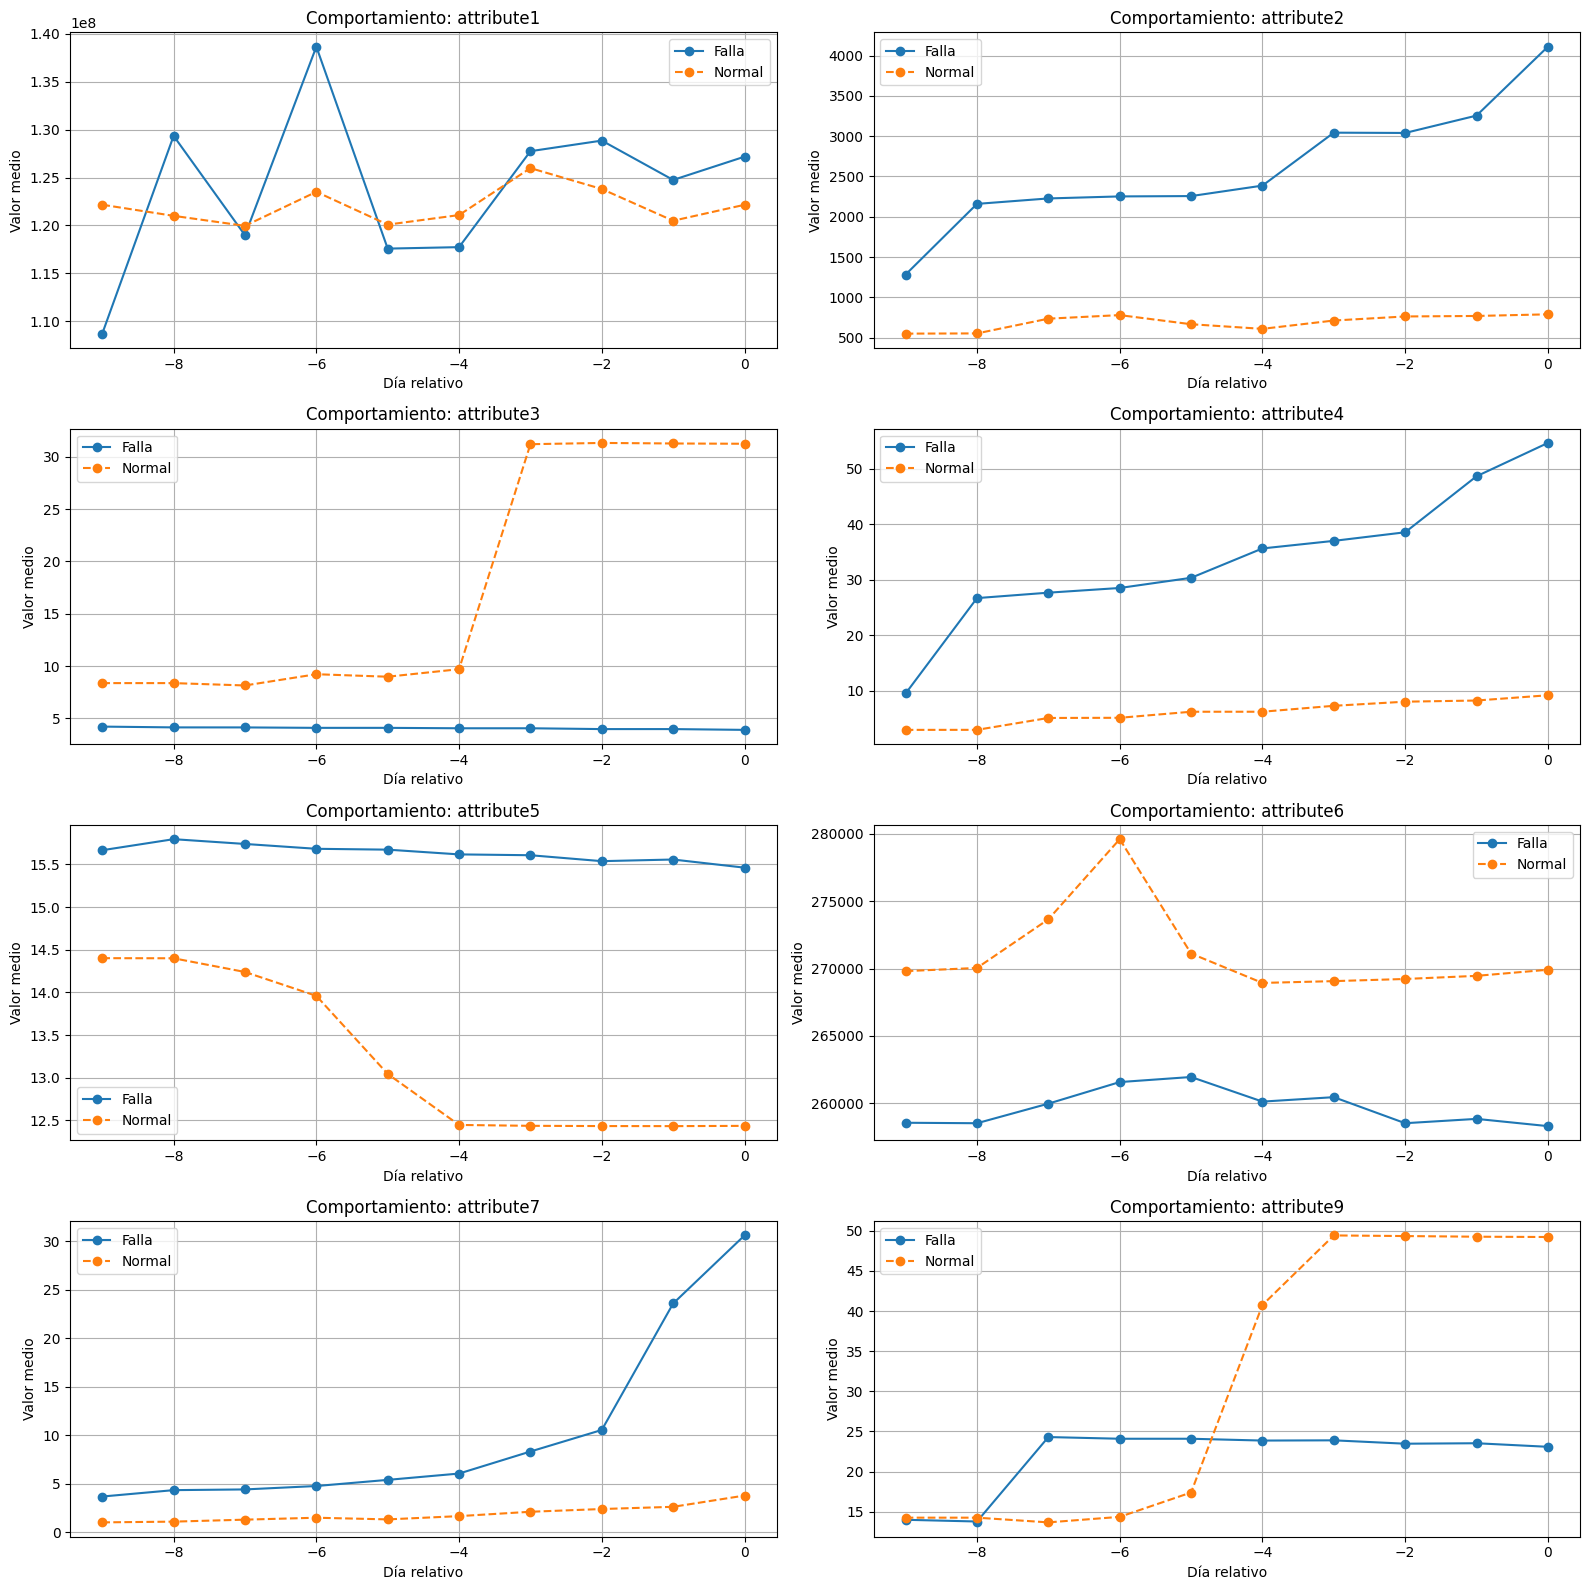

In [12]:

tmp1=historico_falla_df[feature_cols+['relative_day_index']].groupby('relative_day_index').agg(['mean']).reset_index()
tmp2=historico_normal_df[feature_cols+['relative_day_index']].groupby('relative_day_index').agg(['mean']).reset_index()

tmp1.columns=tmp1.columns.map(lambda x: x[0] if len(x) == 1 else '_'.join(x))
tmp2.columns=tmp2.columns.map(lambda x: x[0] if len(x) == 1 else '_'.join(x))

merged = tmp1.merge(tmp2, on='relative_day_index_', suffixes=('_falla', '_normal'))

dias = range(-9, 1)
filtered = merged[merged['relative_day_index_'].isin(dias)]

feature_means_falla = [f"{c}_mean_falla" for c in feature_cols]
feature_means_normal = [f"{c}_mean_normal" for c in feature_cols]

fig, axes = plt.subplots(nrows=len(feature_cols)//2 + len(feature_cols)%2, ncols=2, figsize=(16, 16))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    ax.plot(filtered['relative_day_index_'], filtered[f"{col}_mean_falla"], label='Falla', marker='o')
    ax.plot(filtered['relative_day_index_'], filtered[f"{col}_mean_normal"], label='Normal', marker='o', linestyle='--')
    ax.set_title(f'Comportamiento: {col}')
    ax.set_xlabel('Día relativo')
    ax.set_ylabel('Valor medio')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



In [13]:
## Tenemso attributos que no son relevantes para el modelo

### Análisis del Target (Failure)

In [14]:
print('Distribución de fallas:')
print(df['failure'].value_counts())
print(f'\nPorcentaje de fallas: {df["failure"].mean()*100:.2f}%')
print(f'\nProcentaje de fallas por device unico: {df[['device','failure']].drop_duplicates()["failure"].mean()*100}')
#este comportamiento es por qeu un device no falla tanto en el tiempo, si se mira a nivel de device. la proportcion es menor

Distribución de fallas:
failure
0    124388
1       106
Name: count, dtype: int64

Porcentaje de fallas: 0.09%

Procentaje de fallas por device unico: 8.313725490196077


### Construcción del Target


In [15]:
#como la idea es predecir la falla un día antes  de que falle, se le da un shift a la falla un día antes,
#los valores del target 0 de la falla se retiran. solo si fueron falla
print(f'Shape antes: {df.shape}')

df['target'] = df.sort_values(['device','date']).groupby('device')['failure'].shift(-1)

df['target']=df.apply(lambda x: 0 if x['failure']==0 and x['target']==0 else x['target'],axis=1)

print(f'\nShape después: {df.shape}')
print(f' en target: {df["target"].sum()}')

# Eliminar nulls (última fila de cada device)
df = df.dropna(subset=['target'])
print(f'\nShape final: {df.shape}')
print(f'Distribución target: {df["target"].value_counts().to_dict()}')

Shape antes: (124494, 14)

Shape después: (124494, 15)
 en target: 106.0

Shape final: (123325, 15)
Distribución target: {0.0: 123219, 1.0: 106}


In [16]:
# Creamos una "marca extendida": para cada failure (falla=1), como vimos anteriormente las features se mueven desde antes.

N = 3  # eventos previos a la falla
df['extended_target'] = 0

# Por cada device, marcamos como 1 la fila con target=1 y las N previas
for dev in df['device'].unique():
    idx = df[df['device'] == dev].index
    fails = df.loc[idx, 'target'][df.loc[idx, 'target'] == 1].index
    for fail_idx in fails:
        # Nos aseguramos de no pasarnos al inicio del subconjunto del device
        window_idx = df.loc[idx].loc[:fail_idx].tail(N+1).index
        df.loc[window_idx, 'extended_target'] = 1
print(f'\nShape final: {df.shape}')
print(f'Distribución extended_target: {df["extended_target"].value_counts().to_dict()}')



Shape final: (123325, 16)
Distribución extended_target: {0: 122901, 1: 424}


### Feature Engineering


In [17]:
attributes = [col for col in df.columns if col.startswith('attribute')]
print(f'Attributes: {attributes}')
print(f'Total: {len(attributes)}')
print(f'\nShape antes de features: {df.shape}')

Attributes: ['attribute1', 'attribute2', 'attribute3', 'attribute4', 'attribute5', 'attribute6', 'attribute7', 'attribute9']
Total: 8

Shape antes de features: (123325, 16)


In [18]:
# creando lags son features de como se ve las variables en el tiempo
print('Creando lags...')
for lag in [1, 2, 3,5,7]:
    for attr in attributes:
        df[f'{attr}_lag_{lag}'] = df.groupby('device')[attr].shift(lag).fillna(0)
    print(f'  Lag {lag} creado')

lag_cols = [col for col in df.columns if '_lag_' in col]
print(f'Lag features: {len(lag_cols)}')

Creando lags...
  Lag 1 creado
  Lag 2 creado
  Lag 3 creado
  Lag 5 creado
  Lag 7 creado
Lag features: 40


In [19]:
# acumulados de los datos en el tiempo por promedio y desviacion estandar
print('Creando rolling...')
for window in [1,2,3,5,7, 14]:
    for attr in attributes:
        df[f'{attr}_roll_{window}_mean'] = df.groupby('device')[attr].rolling(window, min_periods=1).mean().fillna(0).values
        df[f'{attr}_roll_{window}_std'] = df.groupby('device')[attr].rolling(window, min_periods=1).std().fillna(0).values
    print(f'  Rolling {window} creado')

roll_cols = [col for col in df.columns if '_roll_' in col]
print(f'Rolling features: {len(roll_cols)}')

Creando rolling...
  Rolling 1 creado
  Rolling 2 creado
  Rolling 3 creado
  Rolling 5 creado
  Rolling 7 creado
  Rolling 14 creado
Rolling features: 96


In [20]:
# 3. Ventanas disjuntas, similar a las rolling pero con ventanas fijas
print('Creando ventanas disjuntas...')
ventanas = [(1,2),(3,4),(4, 7), (8, 14)]

for attr in attributes:
    for start, end in ventanas:
        window_size = end - start + 1
        df[f'{attr}_w{start}_{end}d_mean'] = df.groupby('device')[attr].transform(
            lambda x: x.shift(start).rolling(window_size, min_periods=1).mean().fillna(0)
        )
        df[f'{attr}_w{start}_{end}d_std'] = df.groupby('device')[attr].transform(
            lambda x: x.shift(start).rolling(window_size, min_periods=1).std().fillna(0)
        )
    print(f'  Ventanas para {attr} creadas')

window_cols = [col for col in df.columns if '_w' in col]
print(f'Ventanas disjuntas: {len(window_cols)}')

Creando ventanas disjuntas...
  Ventanas para attribute1 creadas
  Ventanas para attribute2 creadas
  Ventanas para attribute3 creadas
  Ventanas para attribute4 creadas
  Ventanas para attribute5 creadas
  Ventanas para attribute6 creadas
  Ventanas para attribute7 creadas
  Ventanas para attribute9 creadas
Ventanas disjuntas: 64


In [21]:
# Features de diferencias, para ver como se comporta la variable en el tiempo
print('Creando diferencias...')
for diff in [1, 7]:
    for attr in attributes:
        df[f'{attr}_diff_{diff}'] = df.groupby('device')[attr].diff(diff).fillna(0)
    print(f'  Diff {diff} creado')

diff_cols = [col for col in df.columns if '_diff_' in col]
print(f'Difference features: {len(diff_cols)}')

Creando diferencias...
  Diff 1 creado
  Diff 7 creado
Difference features: 16


In [22]:
import pandas as pd
import numpy as np


df['days_since_last_failure'] = (
    df.groupby('device', group_keys=False)
      .apply(lambda g: (
          g['date'] -                    
          g['date'].where(g['failure'].eq(1)) 
                   .ffill()                    
                   .shift(1)                  
      ).dt.days)
).fillna(0)

In [23]:
# Resumen
print('RESUMEN DE FEATURES')
print(f'Attributes originales: {len(attributes)}')
print(f'Lag features: {len(lag_cols)}')
print(f'Rolling features: {len(roll_cols)}')
print(f'Ventanas disjuntas: {len(window_cols)}')
print(f'Difference features: {len(diff_cols)}')
print(f'\nTOTAL FEATURES: {len(attributes) + len(lag_cols) + len(roll_cols) + len(window_cols) + len(diff_cols)}')
print(f'Shape actual: {df.shape}')

# Eliminar nulls
print(f'device unicos antes de eliminar nulls: {df["device"].nunique()}')
df_clean = df.dropna().reset_index(drop=True)
print(f'\nShape después de eliminar nulls: {df_clean.shape}')
print(f'Filas eliminadas: {len(df) - len(df_clean)}')
print(f'device unicos despues de eliminar nulls: {df_clean["device"].nunique()}')

RESUMEN DE FEATURES
Attributes originales: 8
Lag features: 40
Rolling features: 96
Ventanas disjuntas: 64
Difference features: 16

TOTAL FEATURES: 224
Shape actual: (123325, 233)
device unicos antes de eliminar nulls: 1168

Shape después de eliminar nulls: (123325, 233)
Filas eliminadas: 0
device unicos despues de eliminar nulls: 1168


## Datasets

In [24]:
# Para cada device, identificar el último registro 

df_clean = df_clean.sort_values(['device', 'date']).reset_index(drop=True)

last_dates = df_clean.groupby('device')['date'].transform('max')
df_clean['is_last_date_device'] = (df_clean['date'] == last_dates).astype(int)

df_clean['days_from_last'] = (last_dates - df_clean['date']).dt.days

df_clean = df_clean[df_clean['days_from_last'] < 15].copy()

df_clean['is_day_0'] = (df_clean['days_from_last'] == 0).astype(int)

df_clean = df_clean.sort_values(['device', 'date']).reset_index(drop=True)

df_ultimo_vento=df_clean[df_clean['is_last_date_device']==1].copy()

df_eventos=df_clean.copy()


In [25]:
# Generar resumen por cada dataset

def resumen_dataset(df, nombre):
    print(f"\nResumen para {nombre}:")
    print(f'  Shape: {df.shape}')
    print(f'  Dispositivos únicos: {df["device"].nunique() if "device" in df.columns else "N/A"}')
    print(f'  Fechas: {df["date"].min()} a {df["date"].max()}' if "date" in df.columns else "")
    if "failure" in df.columns:
        print(f'  Fallas: {df["failure"].sum()} ({df["failure"].mean()*100:.2f}%)')
    if "target" in df.columns:
        print(f'  Target pos: {df["target"].sum()} ({df["target"].mean()*100:.2f}%)')
    if "extended_target" in df.columns:
        print(f'  Extended Target pos: {df["extended_target"].sum()} ({df["extended_target"].mean()*100:.2f}%)')
    print()

resumen_dataset(df_ultimo_vento, "df_ultimo_vento")
resumen_dataset(df_eventos, "df_eventos")
resumen_dataset(df, "df_eventos")




Resumen para df_ultimo_vento:
  Shape: (1168, 236)
  Dispositivos únicos: 1168
  Fechas: 2015-01-02 00:00:00 a 2015-10-31 00:00:00
  Fallas: 1 (0.09%)
  Target pos: 101.0 (8.65%)
  Extended Target pos: 101 (8.65%)


Resumen para df_eventos:
  Shape: (13260, 236)
  Dispositivos únicos: 1168
  Fechas: 2015-01-01 00:00:00 a 2015-10-31 00:00:00
  Fallas: 4 (0.03%)
  Target pos: 105.0 (0.79%)
  Extended Target pos: 415 (3.13%)


Resumen para df_eventos:
  Shape: (123325, 233)
  Dispositivos únicos: 1168
  Fechas: 2015-01-01 00:00:00 a 2015-10-31 00:00:00
  Fallas: 5 (0.00%)
  Target pos: 106.0 (0.09%)
  Extended Target pos: 424 (0.34%)



## Split Temporal (Train/Test)

**IMPORTANTE:** Split por FECHA, NO por device, al ser una serie con valores mezclados puede existir dataleakge, acciones del pasado son tomadas en el futuro

In [26]:
df_eventos[df_eventos.device=='S1F01E6Y'].sample(2)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,...,attribute3_diff_7,attribute4_diff_7,attribute5_diff_7,attribute6_diff_7,attribute7_diff_7,attribute9_diff_7,days_since_last_failure,is_last_date_device,days_from_last,is_day_0
29,2015-02-16,S1F01E6Y,0,182876688,0,0,0,12,259486,0,...,0.0,0.0,0.0,48.0,0.0,0.0,0.0,1,0,1
20,2015-02-07,S1F01E6Y,0,68029784,0,0,0,12,259428,0,...,0.0,0.0,0.0,65.0,0.0,0.0,0.0,0,9,0


In [27]:
def resumen_dataset(df, nombre):
    print(f"\nResumen para {nombre}:")
    print(f'  Shape: {df.shape}')
    print(f'  Dispositivos únicos: {df["device"].nunique() if "device" in df.columns else "N/A"}')
    print(f'  Fechas: {df["date"].min()} a {df["date"].max()}' if "date" in df.columns else "")
    print(f'  Fallas: {df["target"].sum()} ({df["target"].mean()*100:.2f}%)')

## para serie 
cutoff_date = df_eventos['date'].quantile(0.61)
print(f'Fecha de corte (80/20): {cutoff_date}')
train_eventos = df_eventos[df_eventos['date'] < cutoff_date].copy()
test_eventos = df_eventos[df_eventos['date'] >= cutoff_date].copy()

resumen_dataset(train_eventos, "train_eventos")
resumen_dataset(test_eventos, "test_eventos")

#para ultimo evento
cutoff_date = df_ultimo_vento['date'].quantile(0.7)
print(f'Fecha de corte (80/20): {cutoff_date}')
train_ultimo_vento = df_ultimo_vento[df_ultimo_vento['date'] < cutoff_date].copy()
test_ultimo_vento = df_ultimo_vento[df_ultimo_vento['date'] >= cutoff_date].copy()

resumen_dataset(train_ultimo_vento, "train_ultimo_vento")
resumen_dataset(test_ultimo_vento, "test_ultimo_vento")


Fecha de corte (80/20): 2015-06-30 00:00:00

Resumen para train_eventos:
  Shape: (8085, 236)
  Dispositivos únicos: 826
  Fechas: 2015-01-01 00:00:00 a 2015-06-29 00:00:00
  Fallas: 83.0 (1.03%)

Resumen para test_eventos:
  Shape: (5175, 236)
  Dispositivos únicos: 349
  Fechas: 2015-06-30 00:00:00 a 2015-10-31 00:00:00
  Fallas: 22.0 (0.43%)
Fecha de corte (80/20): 2015-06-24 04:48:00

Resumen para train_ultimo_vento:
  Shape: (817, 236)
  Dispositivos únicos: 817
  Fechas: 2015-01-02 00:00:00 a 2015-06-17 00:00:00
  Fallas: 78.0 (9.55%)

Resumen para test_ultimo_vento:
  Shape: (351, 236)
  Dispositivos únicos: 351
  Fechas: 2015-06-25 00:00:00 a 2015-10-31 00:00:00
  Fallas: 23.0 (6.55%)


In [28]:
train_eventos.to_csv('../data/train_dataset_eventos.csv', index=False)
test_eventos.to_csv('../data/test_dataset_eventos.csv', index=False)
train_ultimo_vento.to_csv('../data/train_dataset_ultimo_vento.csv', index=False)
test_ultimo_vento.to_csv('../data/test_dataset_ultimo_vento.csv', index=False)

In [29]:
"""# Preparar X, y (actualizacion usando extended_target)
exclude_cols = ['date', 'device', 'failure', 'target','last_date', 'last_date_device','first_date_device','extended_target']
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

X_train = train[feature_cols]
y_train = train['extended_target']
X_test = test[feature_cols]
y_test = test['target']

print(feature_cols)
print(f'Features: {len(feature_cols)}')
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}, positivos: {y_train.sum()}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}, positivos: {y_test.sum()}')"""

"# Preparar X, y (actualizacion usando extended_target)\nexclude_cols = ['date', 'device', 'failure', 'target','last_date', 'last_date_device','first_date_device','extended_target']\nfeature_cols = [col for col in df_clean.columns if col not in exclude_cols]\n\nX_train = train[feature_cols]\ny_train = train['extended_target']\nX_test = test[feature_cols]\ny_test = test['target']\n\nprint(feature_cols)\nprint(f'Features: {len(feature_cols)}')\nprint(f'X_train: {X_train.shape}')\nprint(f'y_train: {y_train.shape}, positivos: {y_train.sum()}')\nprint(f'X_test: {X_test.shape}')\nprint(f'y_test: {y_test.shape}, positivos: {y_test.sum()}')"

## Feature Selection

In [ ]:
train_eventos=pd.read_csv('../data/train_dataset_eventos.csv')
test_eventos=pd.read_csv('../data/test_dataset_eventos.csv')
train_ultimo_vento=pd.read_csv('../data/train_dataset_ultimo_vento.csv')
test_ultimo_vento=pd.read_csv('../data/test_dataset_ultimo_vento.csv')

In [ ]:
exclude_cols = ['date', 'device', 'failure', 'target','last_date', 'last_date_device',
'first_date_device','extended_target','days_since_last_failure','is_last_date_device','days_from_last','is_day_0','days_from_last_device']
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]
#feature_cols

In [ ]:
# Feature selection usando Information Value (IV)

def calcula_iv(X, y, bins=10):

    iv_dict = {}
    eps = 1e-6  # para evitar división por cero

    for col in X.columns:
        if X[col].nunique() <= 1:
            iv_dict[col] = 0
            continue

        if np.issubdtype(X[col].dtype, np.number) and X[col].nunique() > bins:
            X_binned = pd.qcut(X[col], q=bins, duplicates='drop')
        else:
            X_binned = X[col]

        temp = pd.DataFrame({'bin': X_binned, 'extended_target': y})
        stats = temp.groupby('bin')['extended_target'].agg(['count', 'sum'])
        stats['non_event'] = stats['count'] - stats['sum']

        event_total = stats['sum'].sum()
        non_event_total = stats['non_event'].sum()

        stats['event_rate'] = stats['sum'] / (event_total + eps)
        stats['non_event_rate'] = stats['non_event'] / (non_event_total + eps)
        woe = np.log((stats['event_rate'] + eps) / (stats['non_event_rate'] + eps))
        iv = ((stats['event_rate'] - stats['non_event_rate']) * woe).sum()
        iv_dict[col] = iv

    iv_series = pd.Series(iv_dict).sort_values(ascending=False)
    return iv_series

iv_series = calcula_iv(train_ultimo_vento[feature_cols], train_ultimo_vento['target'])
selected_features_target = iv_series[iv_series > 0.4].index.tolist()

iv_series = calcula_iv(train_eventos[feature_cols], train_eventos['extended_target'])
selected_features_extended_target = iv_series[iv_series > 0.2].index.tolist()

print("total de features target (ultimo evento):",len(selected_features_target),f'\nFeatures seleccionadas (IV > 0.02): {selected_features_target}')
print("total de features extended_target (eventos):",len(selected_features_extended_target),f'\nFeatures seleccionadas (IV > 0.02): {selected_features_extended_target}')


total de features target (ultimo evento): 73 
Features seleccionadas (IV > 0.02): ['attribute6_roll_14_std', 'attribute5_lag_5', 'attribute6_lag_5', 'attribute1_lag_5', 'attribute1_w4_7d_std', 'attribute7_diff_7', 'attribute5_w8_14d_mean', 'attribute5_lag_7', 'attribute1_w8_14d_mean', 'attribute2_diff_7', 'attribute1_w8_14d_std', 'attribute7_roll_2_std', 'attribute7_diff_1', 'attribute5_w8_14d_std', 'attribute7_w1_2d_std', 'attribute7_lag_5', 'attribute6_lag_7', 'attribute6_w8_14d_mean', 'attribute1_diff_7', 'attribute7_w4_7d_std', 'attribute5_roll_5_std', 'attribute7_w8_14d_std', 'attribute4_w3_4d_std', 'attribute1_lag_7', 'attribute7_lag_7', 'attribute4_roll_2_mean', 'attribute4', 'attribute4_roll_1_mean', 'attribute6_diff_7', 'attribute1_w3_4d_std', 'attribute6_w4_7d_std', 'attribute2_roll_3_mean', 'attribute2', 'attribute2_roll_1_mean', 'attribute2_roll_2_mean', 'attribute5_roll_3_std', 'attribute5_w4_7d_mean', 'attribute5_roll_7_mean', 'attribute5_roll_14_mean', 'attribute4_roll_5

In [ ]:
#iv_series['days_since_last_failure'].round(4)
iv_series['attribute7_diff_7'].round(4)

0.6033

## Modelado Base: XGBoost

**Métrica AUC PR:** ajuste entre positivos y negativos

In [ ]:
#pip install xgboost

#### Historial eventos, con con busqueda de hiperparametros con optuna

In [ ]:
from sklearn.utils import resample

# Actualizar conjuntos de entrenamiento y prueba (subsampleamos train para un 90:10)

print("fallas antes de samplear",train_eventos.extended_target.value_counts(normalize=True))

train_eventos_pos = train_eventos[train_eventos['extended_target'] == 1]
train_eventos_neg = train_eventos[train_eventos['extended_target'] == 0]

n_pos = len(train_eventos_pos)
n_neg = int(n_pos * 10)

train_eventos_neg_sample = resample(
    train_eventos_neg, replace=False,  n_samples=n_neg, random_state=42
)

train_eventos_sample = pd.concat([train_eventos_pos, train_eventos_neg_sample])
train_eventos_sample = train_eventos_sample.sample(frac=1, random_state=42).reset_index(drop=True)

print("fallas despues de samplear",train_eventos_sample.extended_target.value_counts(normalize=True))


X_train = train_eventos_sample[selected_features_extended_target]
X_test = test_eventos[selected_features_extended_target]

y_train = train_eventos_sample['extended_target']
y_test = test_eventos['extended_target']

fallas antes de samplear extended_target
0    0.959431
1    0.040569
Name: proportion, dtype: float64
fallas despues de samplear extended_target
0    0.909091
1    0.090909
Name: proportion, dtype: float64


In [ ]:
#realizar el entranamiento 

import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "subsample": trial.suggest_uniform("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.7, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "scale_pos_weight": (len(y_train) - y_train.sum()) / y_train.sum(),
        "random_state": 42,
        "tree_method": "auto",
        "use_label_encoder": False,
        "eval_metric": "aucpr"
    }
    model = xgb.XGBClassifier(**params)
    # validación interna para evitar sobreajuste en busqueda
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc_pr = average_precision_score(y_val, y_val_pred)
    return auc_pr

study = optuna.create_study(direction="maximize", study_name="xgb_aucpr")
study.optimize(objective, n_trials=100)

print("Mejores parámetros:", study.best_trial.params)
print("Mejor AUC-PR (cv valida):", study.best_value)


[I 2025-10-19 08:18:53,210] A new study created in memory with name: xgb_aucpr


[I 2025-10-19 08:18:54,469] Trial 0 finished with value: 0.7772111805275892 and parameters: {'max_depth': 10, 'learning_rate': 0.052430678993660364, 'n_estimators': 274, 'subsample': 0.9082992935962827, 'colsample_bytree': 0.9734542073998167, 'gamma': 0.09280403611801974, 'reg_alpha': 0.0016957951595109517, 'reg_lambda': 0.05017352413249547}. Best is trial 0 with value: 0.7772111805275892.
[I 2025-10-19 08:18:55,902] Trial 1 finished with value: 0.7416204467607538 and parameters: {'max_depth': 12, 'learning_rate': 0.059348327296345905, 'n_estimators': 324, 'subsample': 0.9823874523411952, 'colsample_bytree': 0.8290562439073916, 'gamma': 0.0011477806644794167, 'reg_alpha': 0.008792412066786007, 'reg_lambda': 4.698402578699287}. Best is trial 0 with value: 0.7772111805275892.
[I 2025-10-19 08:18:57,119] Trial 2 finished with value: 0.5593738414843638 and parameters: {'max_depth': 5, 'learning_rate': 0.003886287431324707, 'n_estimators': 335, 'subsample': 0.743067597716483, 'colsample_byt

Mejores parámetros: {'max_depth': 10, 'learning_rate': 0.027745816713898846, 'n_estimators': 377, 'subsample': 0.8824698130887566, 'colsample_bytree': 0.7869923236661704, 'gamma': 1.3471642348257076e-05, 'reg_alpha': 1.0649212529305546e-06, 'reg_lambda': 1.8155856048269795e-08}
Mejor AUC-PR (cv valida): 0.8029084827583176


In [ ]:

# Entrenamos el modelo final con los mejores parámetros encontrados
best_params = study.best_trial.params
best_params["scale_pos_weight"] = (len(y_train) - y_train.sum()) / y_train.sum()
best_params["random_state"] = 42
best_params["tree_method"] = "auto"
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "aucpr"

print(f'Scale pos weight: {best_params["scale_pos_weight"] :.2f}')

model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train, verbose=False)
print('Modelo entrenado con Optuna y mejores hiperparámetros')


Scale pos weight: 9.47


Modelo entrenado con Optuna y mejores hiperparámetros


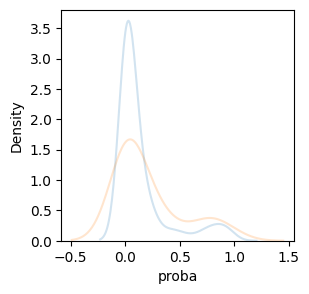

In [ ]:
# Predicciones
y_pred_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

tmp=pd.DataFrame(zip(y_pred_test, y_test)).rename(columns={0:'proba', 1:'target'})

plt.figure(figsize=(3, 3))
sns.kdeplot(tmp[tmp['target']==0],x='proba',alpha=0.2);
sns.kdeplot(tmp[tmp['target']==1],x='proba',alpha=0.2);
#plt.ylim(0,100);


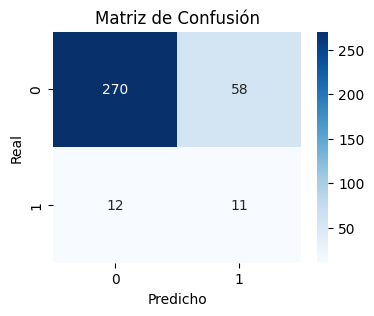

True Negatives: 270
False Positives: 58 (falsas alarmas)
False Negatives: 12 (fallas NO detectadas)
True Positives: 11 (fallas detectadas)
precision: 0.15942028985507245
AUC PR (Average Precision): 0.2557


In [ ]:
# Matriz de confusión
threshold = 0.05
y_pred_th = (y_pred_test > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f'True Negatives: {tn}')
print(f'False Positives: {fp} (falsas alarmas)')
print(f'False Negatives: {fn} (fallas NO detectadas)')
print(f'True Positives: {tp} (fallas detectadas)')
print(f"precision: {tp/(tp+fp)}")

aucpr = average_precision_score(y_test, y_pred_prob)
print(f"AUC PR (Average Precision): {aucpr:.4f}")

In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature':selected_features_extended_target,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print('Top 20 features:')
print(feature_importance.head(10))

Top 20 features:
                    feature  importance
20         attribute5_lag_7    0.112019
16               attribute2    0.091072
17   attribute2_roll_1_mean    0.070320
12   attribute4_roll_2_mean    0.047601
22   attribute4_roll_3_mean    0.041518
1         attribute7_diff_7    0.037872
27         attribute5_lag_5    0.029152
13   attribute5_w8_14d_mean    0.028892
26  attribute2_roll_14_mean    0.026392
65   attribute6_roll_3_mean    0.025839


In [1227]:
model.save_model('../models/model_xgb_extended_target.json')

#### Modelos con ultimo eventos y agregamos SMOTE

In [ ]:

# Actualizar conjuntos de entrenamiento y prueba (subsampleamos train para un 90:10)

print("fallas antes de samplear",train_ultimo_vento.extended_target.value_counts(normalize=True))

X_train = train_ultimo_vento[selected_features_target]
X_test = test_ultimo_vento[selected_features_target]

y_train = train_ultimo_vento['target']
y_test = test_ultimo_vento['target']


fallas antes de samplear extended_target
0    0.904529
1    0.095471
Name: proportion, dtype: float64


In [ ]:
# Optuna con SMOTE para balancear la clase minoritaria (85:15) No invasivo 
from imblearn.over_sampling import SMOTE


def objective_smote(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "subsample": trial.suggest_uniform("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.7, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
        "scale_pos_weight": (len(y_train) - y_train.sum()) / y_train.sum(),
        "random_state": 42,
        "tree_method": "auto",
        "use_label_encoder": False,
        "eval_metric": "aucpr"
    }
    # Split train/validation
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    # Aplicar SMOTE para rebalancear la clase minoritaria a 10% (ratio 0.1)
    sm = SMOTE(sampling_strategy=0.15, random_state=42)
    X_tr_sm, y_tr_sm = sm.fit_resample(X_tr, y_tr)
    model = xgb.XGBClassifier(**params)
    model.fit(X_tr_sm, y_tr_sm, eval_set=[(X_val, y_val)], verbose=False)
    y_val_pred = model.predict_proba(X_val)[:, 1]
    auc_pr = average_precision_score(y_val, y_val_pred)
    return auc_pr

study_smote = optuna.create_study(direction="maximize", study_name="xgb_aucpr_smote")
study_smote.optimize(objective_smote, n_trials=100)

print("Mejores parámetros con SMOTE:", study_smote.best_trial.params)
print("Mejor AUC-PR (cv valida, SMOTE):", study_smote.best_value)


[I 2025-10-19 08:28:22,660] A new study created in memory with name: xgb_aucpr_smote


[I 2025-10-19 08:28:23,503] Trial 0 finished with value: 0.4724326911910231 and parameters: {'max_depth': 7, 'learning_rate': 0.002451019087684689, 'n_estimators': 284, 'subsample': 0.8223646166454067, 'colsample_bytree': 0.7760497430720757, 'gamma': 2.2067965676594422e-07, 'reg_alpha': 0.35502421949985496, 'reg_lambda': 0.018588608731422585}. Best is trial 0 with value: 0.4724326911910231.
[I 2025-10-19 08:28:24,978] Trial 1 finished with value: 0.5217267539289765 and parameters: {'max_depth': 12, 'learning_rate': 0.0005622006077116274, 'n_estimators': 437, 'subsample': 0.7025728439214346, 'colsample_bytree': 0.749011688751096, 'gamma': 0.5014288788392889, 'reg_alpha': 8.07462212721365e-06, 'reg_lambda': 2.2602415995535868e-05}. Best is trial 1 with value: 0.5217267539289765.
[I 2025-10-19 08:28:25,243] Trial 2 finished with value: 0.40308454077198114 and parameters: {'max_depth': 4, 'learning_rate': 0.00014180925541635173, 'n_estimators': 118, 'subsample': 0.8350024975289156, 'colsam

Mejores parámetros con SMOTE: {'max_depth': 3, 'learning_rate': 0.06177401357230063, 'n_estimators': 293, 'subsample': 0.9248326616910855, 'colsample_bytree': 0.9823400091822234, 'gamma': 4.106712271732638e-08, 'reg_alpha': 2.7775082216091577e-08, 'reg_lambda': 1.0144375188819201}
Mejor AUC-PR (cv valida, SMOTE): 0.7864289251816192


In [ ]:

# Entrenamos el modelo final con los mejores parámetros encontrados
best_params = study_smote.best_trial.params
best_params["scale_pos_weight"] = (len(y_train) - y_train.sum()) / y_train.sum()
best_params["random_state"] = 42
best_params["tree_method"] = "auto"
best_params["use_label_encoder"] = False
best_params["eval_metric"] = "aucpr"

model_smote = xgb.XGBClassifier(**best_params)
model_smote.fit(X_train, y_train, verbose=False)
print('Modelo entrenado con Optuna y mejores hiperparámetros')


Modelo entrenado con Optuna y mejores hiperparámetros


In [ ]:
# Predicciones
y_pred_prob = model_smote.predict_proba(X_test)[:, 1]
y_pred = model_smote.predict(X_test)

tmp=pd.DataFrame(zip(y_pred_prob, y_test)).rename(columns={0:'proba', 1:'target'})



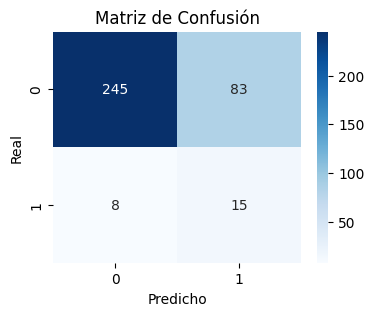

True Negatives: 245
False Positives: 83 (falsas alarmas)
False Negatives: 8 (fallas NO detectadas)
True Positives: 15 (fallas detectadas)
precision: 0.15306122448979592
AUC PR (Average Precision): 0.2246


In [ ]:
# Matriz de confusión
threshold = 0.05
y_pred_th = (y_pred > threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f'True Negatives: {tn}')
print(f'False Positives: {fp} (falsas alarmas)')
print(f'False Negatives: {fn} (fallas NO detectadas)')
print(f'True Positives: {tp} (fallas detectadas)')
print(f"precision: {tp/(tp+fp)}")

aucpr = average_precision_score(y_test, y_pred_prob)
print(f"AUC PR (Average Precision): {aucpr:.4f}")


In [1228]:
model_smote.save_model('../models/modelo_ultimo_evento.json')

## Modelado con LSTM



### procesamiento de datos

In [ ]:
path='../data/full_devices.csv'
df = pd.read_csv(path, encoding='Latin-1')
df.head(2)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0


In [ ]:
#movemos el target para ver un dia antes de la falla, y eliminamos el ultimo registro de falla. 
print(f'Shape antes: {df.shape}')

df['target'] = df.sort_values(['device','date']).groupby('device')['failure'].shift(-1)

print(f'\nShape después: {df.shape}')
print(f'Nulls en target: {df["target"].isna().sum()}')

# Eliminar nulls (última fila de cada device)
df = df.dropna(subset=['target'])
print(f'\nShape final: {df.shape}')
print(f'Distribución target: {df["target"].value_counts().to_dict()}')

df['date'] = pd.to_datetime(df['date'])

Shape antes: (124494, 12)

Shape después: (124494, 13)
Nulls en target: 1169

Shape final: (123325, 13)
Distribución target: {0.0: 123219, 1.0: 106}


In [ ]:

window_size = 15
features_lstm = [col for col in df.columns if col not in ['date', 'device', 'failure','target','extended_target']]
X_lstm = []
y_lstm = []
device_ids = []

# Ordenamos por device y fecha para que las ventanas tengan sentido cronológicamente
df_sorted = df.sort_values(['device', 'date']).reset_index(drop=True)

for device, device_df in df_sorted.groupby('device'):
    device_df = device_df.reset_index(drop=True)
    for i in range(window_size, len(device_df)):
        window_features = device_df.loc[i-window_size:i-1, features_lstm].values
        target = device_df.loc[i, 'target']
        X_lstm.append(window_features)
        y_lstm.append(target)
        device_ids.append(device)

X_lstm = np.array(X_lstm)
y_lstm = np.array(y_lstm)
device_ids = np.array(device_ids)

print(f'Forma de X_lstm: {X_lstm.shape}')
print(f'Primer shape ventana: {X_lstm[0].shape}')
print(f'Y_lstm ejemplo: {y_lstm[:10]}')

# df_lstm es para referencia de device y fecha objetivo si queremos invocar luego
df_lstm_meta = df_sorted.groupby('device').apply(lambda d: d.iloc[window_size:][['device', 'date']]).reset_index(drop=True)


Forma de X_lstm: (109643, 15, 9)
Primer shape ventana: (15, 9)
Y_lstm ejemplo: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
#tenemos nuestro dataset con los registros, cada uno con su ventana de 15 registros X featueres
X_lstm.shape

(109643, 15, 9)

In [ ]:


# Ordenar por fecha, obtener el percentil 80 para cutoff
cutoff_date = df_lstm_meta['date'].quantile(0.8)

# Entrenamiento y test usando la fecha como corte
train_idx = df_lstm_meta['date'] <= cutoff_date
test_idx = df_lstm_meta['date'] > cutoff_date

X_train, X_test = X_lstm[train_idx], X_lstm[test_idx]
y_train, y_test = y_lstm[train_idx], y_lstm[test_idx]

print(f"Tamaño train: {X_train.shape[0]}, test: {X_test.shape[0]}")
print(f"Fecha inicial train: {df_lstm_meta['date'][train_idx].min()}, Fecha final train: {df_lstm_meta['date'][train_idx].max()}")
print(f"Fecha inicial test: {df_lstm_meta['date'][test_idx].min()}, Fecha final test: {df_lstm_meta['date'][test_idx].max()}")
print("target train: ", y_train.sum(), "target test: ", y_test.sum())


Tamaño train: 87810, test: 21833
Fecha inicial train: 2015-01-16 00:00:00, Fecha final train: 2015-07-12 00:00:00
Fecha inicial test: 2015-07-13 00:00:00, Fecha final test: 2015-10-31 00:00:00
target train:  81.0 target test:  16.0


### crear modelo LSTM

In [ ]:

feature_cols =['attribute1','attribute2','attribute3','attribute4','attribute5','attribute6','attribute7','attribute9']

train_eventos.device.drop_duplicates().count()

826

In [ ]:

n_timesteps = 15
target_col = 'target'  

# crear tensor para la lstm basado en device e historial de atributos
def create_lstm_data(df, feature_cols, target_col, n_timesteps):    

    X_list, y_list, ref_meta = [], [], []

    for dev, g in df.groupby('device'):
        g = g.reset_index(drop=True)

        X_dev = g[feature_cols].to_numpy(dtype='float32')

        if len(X_dev) < n_timesteps:
            pad_len = n_timesteps - len(X_dev)
            pad = np.zeros((pad_len, X_dev.shape[1]), dtype='float32')
            X_dev = np.vstack([pad, X_dev])

        y_value = g[target_col].iloc[-1] if target_col in g.columns else g['failure'].iloc[-1]

        X_list.append(X_dev)
        y_list.append(y_value)
        ref_meta.append(dev)
    return np.stack(X_list), np.array(y_list, dtype='float32'), np.array(ref_meta)

# --- convertir a tensores 

X_train_lstm, y_train_lstm, ref_meta = create_lstm_data(train_eventos, feature_cols, target_col, n_timesteps)
X_test_lstm, y_test_lstm, ref_meta_test = create_lstm_data(test_eventos, feature_cols, target_col, n_timesteps)

print("Shape X:", X_train_lstm.shape, "Shape y:", y_train_lstm.shape)
print("Shape X:", X_test_lstm.shape, "Shape y:", y_test_lstm.shape)



Shape X: (826, 15, 8) Shape y: (826,)
Shape X: (349, 15, 8) Shape y: (349,)


In [ ]:
sample_idx = 3
pd.DataFrame(X_train_lstm[sample_idx]) 
#train_eventos[train_eventos.device == meta[sample_idx]]

,0,1,2,3,4,5,6,7
0,230172272.0,0.0,0.0,0.0,12.0,259363.0,0.0,0.0
1,129496320.0,0.0,0.0,0.0,12.0,259363.0,0.0,0.0
2,36442656.0,0.0,0.0,0.0,12.0,259365.0,0.0,0.0
3,49528440.0,0.0,0.0,0.0,12.0,259365.0,0.0,0.0
4,25414696.0,0.0,0.0,0.0,12.0,259365.0,0.0,0.0
5,68029784.0,0.0,0.0,0.0,12.0,259428.0,0.0,0.0
6,156867520.0,0.0,0.0,0.0,12.0,259433.0,0.0,0.0
7,121080488.0,0.0,0.0,0.0,12.0,259438.0,0.0,0.0
8,85168544.0,0.0,0.0,0.0,12.0,259443.0,0.0,0.0
9,57781112.0,0.0,0.0,0.0,12.0,259450.0,0.0,0.0


In [ ]:
## Separar train pra validacion de la LSTM

split = int(0.8 * len(X_train_lstm))
X_train_lstm_red, X_test_lstm_red = X_train_lstm[:split], X_train_lstm[split:]
y_train_lstm_red, y_test_lstm_red = y_train_lstm[:split], y_train_lstm[split:]

print("Shape X:", X_train_lstm_red.shape, "Shape y:", y_train_lstm_red.shape)


Shape X: (660, 15, 8) Shape y: (660,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LayerNormalization
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam

# Definiendo el modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(n_timesteps, n_features), return_sequences=True))
model_lstm.add(LayerNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(16, return_sequences=False))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1, activation='sigmoid'))  # Clasificación binaria

optimizer = Adam(learning_rate=0.0001)
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy','precision','recall']
)

# Entrenamiento con early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

classes = np.unique(y_train_lstm_red)
weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train_lstm_red)
class_weight_dict = dict(zip(classes, weights))
print(f"Class weights: {class_weight_dict}")


Class weights: {0.0: 0.5509181969949917, 1.0: 5.409836065573771}


In [ ]:

# Entrenar el modelo con class_weight
history = model_lstm.fit(
    X_train_lstm_red, y_train_lstm_red, 
    validation_data=(X_test_lstm_red, y_test_lstm_red),
    epochs=60,
    batch_size=16,
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=2
)


Epoch 1/60


42/42 - 7s - 163ms/step - accuracy: 0.6970 - loss: 0.6809 - precision: 0.1610 - recall: 0.5410 - val_accuracy: 0.6627 - val_loss: 0.6161 - val_precision: 0.2466 - val_recall: 0.9474
Epoch 2/60
42/42 - 0s - 8ms/step - accuracy: 0.6106 - loss: 0.6565 - precision: 0.1423 - recall: 0.6393 - val_accuracy: 0.6627 - val_loss: 0.5799 - val_precision: 0.2466 - val_recall: 0.9474
Epoch 3/60
42/42 - 0s - 9ms/step - accuracy: 0.5652 - loss: 0.6238 - precision: 0.1491 - recall: 0.7869 - val_accuracy: 0.6627 - val_loss: 0.5510 - val_precision: 0.2466 - val_recall: 0.9474
Epoch 4/60
42/42 - 0s - 9ms/step - accuracy: 0.5621 - loss: 0.6028 - precision: 0.1587 - recall: 0.8689 - val_accuracy: 0.6627 - val_loss: 0.5631 - val_precision: 0.2466 - val_recall: 0.9474
Epoch 5/60
42/42 - 0s - 9ms/step - accuracy: 0.5591 - loss: 0.6031 - precision: 0.1577 - recall: 0.8689 - val_accuracy: 0.6627 - val_loss: 0.5522 - val_precision: 0.2466 - val_recall: 0.9474
Epoch 6/60
42/42 - 0s - 9ms/step - accuracy: 0.5591 - 

In [ ]:

# Evaluar el modelo
score = model_lstm.evaluate( X_test_lstm , y_test_lstm, verbose=0)
print(f"Test loss: {score[0]:.4f}, Test accuracy: {score[1]:.4f}")


Test loss: 1.0233, Test accuracy: 0.0602


[1.0233031511306763, 0.06017192080616951, 0.06017192080616951, 1.0]

In [ ]:
# Predicciones
y_proba = model_lstm.predict(X_test_lstm, batch_size=10).ravel()

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
tmp=pd.DataFrame(zip(y_proba, y_test_lstm)).rename(columns={0:'proba', 1:'target'})
tmp.groupby('target').agg({'proba':'mean'}).sort_values(by='proba', ascending=False)

,proba
target,
0.0,0.654047
1.0,0.652940


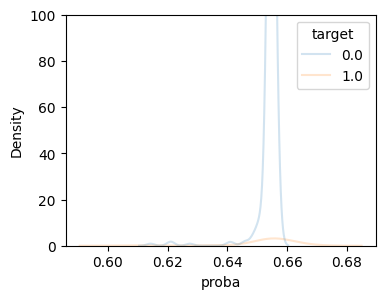

In [ ]:
# Predicciones
plt.figure(figsize=(4, 3))
sns.kdeplot(tmp,hue='target',x='proba',alpha=0.2);
plt.ylim(0,100);


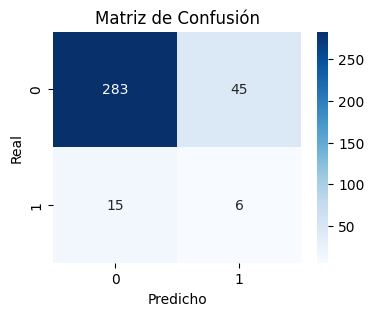

True Negatives: 283
False Positives: 45 (falsas alarmas)
False Negatives: 15 (fallas NO detectadas - CRÍTICO)
True Positives: 6 (fallas detectadas)
precision: 0.11764705882352941
AUC PR (Average Precision): 0.2895


In [ ]:
# Matriz de confusión
threshold = 0.65478
y_pred_th = (y_proba > threshold).astype(int)

cm = confusion_matrix(y_test_lstm, y_pred_th)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f'True Negatives: {tn}')
print(f'False Positives: {fp} (falsas alarmas)')
print(f'False Negatives: {fn} (fallas NO detectadas - CRÍTICO)')
print(f'True Positives: {tp} (fallas detectadas)')
print(f'precision: {tp/(tp+fp)}')

aucpr = average_precision_score(y_test_lstm, y_proba)
print(f"AUC PR (Average Precision): {aucpr:.4f}")


In [1152]:
import pickle
pickle.dump(model_lstm, open('../models/model_lstm.pkl', 'wb'))

## Modelado con Survival Forest

In [1175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
import warnings
warnings.filterwarnings('ignore')


### split de datasets

In [1198]:
exclude_cols = ['date', 'device', 'failure', 'target','last_date', 'last_date_device',
'first_date_device','extended_target','days_since_last_failure','is_last_date_device','days_from_last','is_day_0','days_from_last_device']
feature_cols = [col for col in df_clean.columns if col not in exclude_cols]
#feature_cols =['attribute1','attribute2','attribute3','attribute4','attribute5','attribute6','attribute7','attribute9']

train_eventos['date']=pd.to_datetime(train_eventos['date'])
test_eventos['date']=pd.to_datetime(test_eventos['date'])

In [1199]:
## train and test

X_train = train_eventos[feature_cols].values
X_test = test_eventos[feature_cols].values

# Crear structured arrays para scikit-survival
y_train = Surv.from_arrays(
    event=train_eventos['target'].values,
    time=train_eventos['date'].values
)

y_test = Surv.from_arrays(
    event=test_eventos['target'].values,
    time=test_eventos['date'].values
)

print(f"✓ Features preparadas: {len(feature_cols)} variables")
print(f"✓ Train: {X_train.shape}")
print(f"✓ Test: {X_test.shape}")

# Normalización (importante para algunos features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


✓ Features preparadas: 224 variables
✓ Train: (8085, 224)
✓ Test: (5175, 224)


### Modelo train Survival

In [1200]:
from sksurv.ensemble import RandomSurvivalForest

rsf = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
    verbose=0,
    max_depth=None
)

rsf.fit(X_train_scaled, y_train)

print("Modelo entrenado exitosamente")


Modelo entrenado exitosamente


In [1201]:

train_c_index = rsf.score(X_train_scaled, y_train)
test_c_index = rsf.score(X_test_scaled, y_test)

print(f"   Train: {train_c_index:.4f}")
print(f"   Test:  {test_c_index:.4f}")
print(f"   Diferencia: {abs(train_c_index - test_c_index):.4f}")

if abs(train_c_index - test_c_index) < 0.05:
    print("Buen balance - no hay overfitting significativo")
elif abs(train_c_index - test_c_index) < 0.10:
    print("Ligero overfitting")
else:
    print("Posible overfitting - considerar regularización")

print(f"Interpretación del C-index:")
if test_c_index > 0.8:
    print("Excelente capacidad predictiva (>0.80)")
elif test_c_index > 0.7:
    print(" Buena capacidad predictiva (0.70-0.80)")
elif test_c_index > 0.6:
    print("Capacidad predictiva moderada (0.60-0.70)")
else:
    print(" Capacidad predictiva limitada (<0.60)")


   Train: 0.9939
   Test:  0.7231
   Diferencia: 0.2708
Posible overfitting - considerar regularización
Interpretación del C-index:
 Buena capacidad predictiva (0.70-0.80)


In [1204]:

risk_scores_test = rsf.predict(X_test_scaled)/100

# Crear DataFrame de resultados
results_df = pd.DataFrame({
    'device': test_eventos['device'].values,
    'date': test_eventos['date'].values,
    'risk_score': risk_scores_test,
    'failure': test_eventos['failure'].values,
    'date': test_eventos['date'].values
})
results_df


,device,date,risk_score,failure
0,S1F01R2B,2015-08-09,0.009050,0
1,S1F01R2B,2015-08-10,0.008800,0
2,S1F01R2B,2015-08-11,0.009315,0
3,S1F01R2B,2015-08-12,0.008550,0
4,S1F01R2B,2015-08-13,0.007370,0
...,...,...,...,...
5170,Z1F1VMZB,2015-10-14,0.004450,0
5171,Z1F1VMZB,2015-10-15,0.004050,0
5172,Z1F1VMZB,2015-10-16,0.005665,0
5173,Z1F1VMZB,2015-10-17,0.005750,0


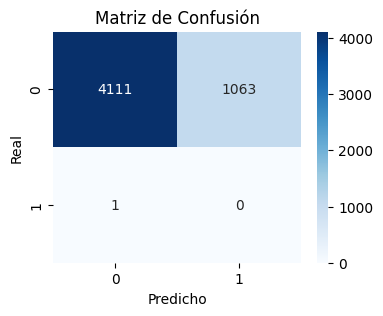

True Negatives: 4111
False Positives: 1063 (falsas alarmas)
False Negatives: 1 (fallas NO detectadas - CRÍTICO)
True Positives: 0 (fallas detectadas)
precision: 0.0
AUC PR (Average Precision): 0.0003


In [1206]:
# Matriz de confusión
threshold = 0.05
y_pred_th = (results_df.risk_score > threshold).astype(int)

cm = confusion_matrix(results_df.failure, y_pred_th)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f'True Negatives: {tn}')
print(f'False Positives: {fp} (falsas alarmas)')
print(f'False Negatives: {fn} (fallas NO detectadas - CRÍTICO)')
print(f'True Positives: {tp} (fallas detectadas)')
print(f'precision: {tp/(tp+fp)}')   

aucpr = average_precision_score(results_df.failure, results_df.risk_score)
print(f"AUC PR (Average Precision): {aucpr:.4f}")
